<a href="https://colab.research.google.com/github/aimbsg/EVA4_S6/blob/master/2_EVA4S6_With_L1_No_L2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Target - Along with batch normalization dropout(0.05) is added IN ALL LAYERS EXCEPT LAST LAYER and image augmentation is used. Global Average Pooling is introduced and expecting to hit 99.4% consistently.

Result - Best accuracy : 99.06%(train) 99.46%(test) ; Params : 8,936

Analysis - No overfit in the model is observed. Train accuracy is less than test accuracy complementing the use of regularization and augmentation strategies. Final few epochs are above 99.4% consistently. 

Regularization - L1 only

# Import Libraries

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [0]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-10.0, 10.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [3]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


# Dataloader Arguments & Test/Train Dataloaders


In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# Data Statistics

It is important to know your data very well. Let's check some of the statistics around our data and how it actually looks like

In [0]:
# # We'd need to convert it into Numpy! Remember above we have converted it into tensors already
# train_data = train.train_data
# train_data = train.transform(train_data.numpy())

# print('[Train]')
# print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
# print(' - Tensor Shape:', train.train_data.size())
# print(' - min:', torch.min(train_data))
# print(' - max:', torch.max(train_data))
# print(' - mean:', torch.mean(train_data))
# print(' - std:', torch.std(train_data))
# print(' - var:', torch.var(train_data))

# dataiter = iter(train_loader)
# images, labels = dataiter.next()

# print(images.shape)
# print(labels.shape)

# # Let's visualize some of the images
# %matplotlib inline
# import matplotlib.pyplot as plt

# plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')


## MORE

It is important that we view as many images as possible. This is required to get some idea on image augmentation later on

In [0]:
# %matplotlib inline
# import matplotlib.pyplot as plt

# figure = plt.figure()
# num_of_images = 60
# for index in range(1, num_of_images + 1):
#     plt.subplot(6, 10, index)
#     plt.axis('off')
#     plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

# The model
Let's start with the model we first saw

In [0]:
dropout_value = 0.05
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_value)
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 24

        # TRANSITION BLOCK 1
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 24
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_value)
        ) # output_size = 10
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 8
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 6
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(32),
            nn.Dropout(dropout_value)
        ) # output_size = 4
        
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=4)
        ) # output_size = 1

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            # nn.BatchNorm2d(10),
            # nn.ReLU(),
            # nn.Dropout(dropout_value)
        ) 


        self.dropout = nn.Dropout(dropout_value)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.gap(x)        
        x = self.convblock8(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

In [0]:
dropout_value = 0.05
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_value)
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 24

        # TRANSITION BLOCK 1
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 24
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_value)
        ) # output_size = 10
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_value)
        ) # output_size = 8
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 6
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(32),
            nn.Dropout(dropout_value)
        ) # output_size = 4
        
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=4)
        ) # output_size = 1

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            # nn.BatchNorm2d(10),
            # nn.ReLU(),
            # nn.Dropout(dropout_value)
        ) 


        self.dropout = nn.Dropout(dropout_value)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.gap(x)        
        x = self.convblock8(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [8]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
       BatchNorm2d-3            [-1, 8, 26, 26]              16
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           1,152
              ReLU-6           [-1, 16, 24, 24]               0
       BatchNorm2d-7           [-1, 16, 24, 24]              32
           Dropout-8           [-1, 16, 24, 24]               0
            Conv2d-9           [-1, 10, 24, 24]             160
        MaxPool2d-10           [-1, 10, 12, 12]               0
           Conv2d-11            [-1, 8, 10, 10]             720
             ReLU-12            [-1, 8, 10, 10]               0
      BatchNorm2d-13            [-1, 8, 10, 10]              16
          Dropout-14            [-

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [0]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    #L1 loss
    reg_loss = 0
    factor = 0.001
    for param in model.parameters():
      reg_loss += torch.sum(abs(param))

    #Sum losses
    loss = loss + (factor * reg_loss)  

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

# Let's Train and test our model

In [10]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

EPOCHS = 40
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.5132126808166504 Batch_id=468 Accuracy=89.78: 100%|██████████| 469/469 [00:19<00:00, 23.87it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1072, Accuracy: 9687/10000 (96.87%)

EPOCH: 1


Loss=0.3424905240535736 Batch_id=468 Accuracy=96.98: 100%|██████████| 469/469 [00:19<00:00, 23.71it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0895, Accuracy: 9748/10000 (97.48%)

EPOCH: 2


Loss=0.40987342596054077 Batch_id=468 Accuracy=97.05: 100%|██████████| 469/469 [00:19<00:00, 23.55it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0724, Accuracy: 9787/10000 (97.87%)

EPOCH: 3


Loss=0.3083111047744751 Batch_id=468 Accuracy=97.19: 100%|██████████| 469/469 [00:19<00:00, 23.50it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0599, Accuracy: 9813/10000 (98.13%)

EPOCH: 4


Loss=0.305463582277298 Batch_id=468 Accuracy=97.39: 100%|██████████| 469/469 [00:20<00:00, 23.21it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0594, Accuracy: 9830/10000 (98.30%)

EPOCH: 5


Loss=0.31967711448669434 Batch_id=468 Accuracy=97.39: 100%|██████████| 469/469 [00:19<00:00, 25.87it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0632, Accuracy: 9821/10000 (98.21%)

EPOCH: 6


Loss=0.2753405272960663 Batch_id=468 Accuracy=97.51: 100%|██████████| 469/469 [00:19<00:00, 23.62it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0631, Accuracy: 9811/10000 (98.11%)

EPOCH: 7


Loss=0.4268656373023987 Batch_id=468 Accuracy=97.40: 100%|██████████| 469/469 [00:19<00:00, 23.82it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0539, Accuracy: 9839/10000 (98.39%)

EPOCH: 8


Loss=0.27395862340927124 Batch_id=468 Accuracy=97.40: 100%|██████████| 469/469 [00:19<00:00, 23.80it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0577, Accuracy: 9816/10000 (98.16%)

EPOCH: 9


Loss=0.33577480912208557 Batch_id=468 Accuracy=97.48: 100%|██████████| 469/469 [00:19<00:00, 23.45it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0549, Accuracy: 9843/10000 (98.43%)

EPOCH: 10


Loss=0.2713117003440857 Batch_id=468 Accuracy=97.53: 100%|██████████| 469/469 [00:19<00:00, 23.55it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0550, Accuracy: 9822/10000 (98.22%)

EPOCH: 11


Loss=0.3019801676273346 Batch_id=468 Accuracy=97.43: 100%|██████████| 469/469 [00:19<00:00, 23.68it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0544, Accuracy: 9839/10000 (98.39%)

EPOCH: 12


Loss=0.3388954997062683 Batch_id=468 Accuracy=97.50: 100%|██████████| 469/469 [00:20<00:00, 23.37it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0707, Accuracy: 9788/10000 (97.88%)

EPOCH: 13


Loss=0.2740608751773834 Batch_id=468 Accuracy=97.42: 100%|██████████| 469/469 [00:19<00:00, 23.49it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0662, Accuracy: 9812/10000 (98.12%)

EPOCH: 14


Loss=0.3143709897994995 Batch_id=468 Accuracy=97.46: 100%|██████████| 469/469 [00:19<00:00, 23.53it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0458, Accuracy: 9859/10000 (98.59%)

EPOCH: 15


Loss=0.30102503299713135 Batch_id=468 Accuracy=97.47: 100%|██████████| 469/469 [00:19<00:00, 23.59it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0598, Accuracy: 9806/10000 (98.06%)

EPOCH: 16


Loss=0.2750121057033539 Batch_id=468 Accuracy=97.52: 100%|██████████| 469/469 [00:19<00:00, 30.06it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0437, Accuracy: 9857/10000 (98.57%)

EPOCH: 17


Loss=0.3147633671760559 Batch_id=468 Accuracy=97.34: 100%|██████████| 469/469 [00:19<00:00, 27.47it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0461, Accuracy: 9853/10000 (98.53%)

EPOCH: 18


Loss=0.3398156762123108 Batch_id=468 Accuracy=97.34: 100%|██████████| 469/469 [00:19<00:00, 23.63it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0554, Accuracy: 9833/10000 (98.33%)

EPOCH: 19


Loss=0.25312167406082153 Batch_id=468 Accuracy=97.39: 100%|██████████| 469/469 [00:20<00:00, 23.34it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0511, Accuracy: 9847/10000 (98.47%)

EPOCH: 20


Loss=0.3031441271305084 Batch_id=468 Accuracy=97.44: 100%|██████████| 469/469 [00:20<00:00, 23.23it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0710, Accuracy: 9782/10000 (97.82%)

EPOCH: 21


Loss=0.2877528965473175 Batch_id=468 Accuracy=97.39: 100%|██████████| 469/469 [00:19<00:00, 23.50it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0539, Accuracy: 9835/10000 (98.35%)

EPOCH: 22


Loss=0.2501203119754791 Batch_id=468 Accuracy=97.38: 100%|██████████| 469/469 [00:20<00:00, 23.38it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1769, Accuracy: 9410/10000 (94.10%)

EPOCH: 23


Loss=0.21832376718521118 Batch_id=468 Accuracy=97.37: 100%|██████████| 469/469 [00:20<00:00, 23.33it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0579, Accuracy: 9797/10000 (97.97%)

EPOCH: 24


Loss=0.3471985459327698 Batch_id=468 Accuracy=97.36: 100%|██████████| 469/469 [00:19<00:00, 23.46it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0636, Accuracy: 9807/10000 (98.07%)

EPOCH: 25


Loss=0.22897371649742126 Batch_id=468 Accuracy=97.49: 100%|██████████| 469/469 [00:20<00:00, 23.38it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0737, Accuracy: 9780/10000 (97.80%)

EPOCH: 26


Loss=0.24311526119709015 Batch_id=468 Accuracy=97.41: 100%|██████████| 469/469 [00:20<00:00, 28.64it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0962, Accuracy: 9696/10000 (96.96%)

EPOCH: 27


Loss=0.31777340173721313 Batch_id=468 Accuracy=97.44: 100%|██████████| 469/469 [00:19<00:00, 29.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0522, Accuracy: 9833/10000 (98.33%)

EPOCH: 28


Loss=0.32409730553627014 Batch_id=468 Accuracy=97.40: 100%|██████████| 469/469 [00:20<00:00, 23.18it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0685, Accuracy: 9795/10000 (97.95%)

EPOCH: 29


Loss=0.40627509355545044 Batch_id=468 Accuracy=97.36: 100%|██████████| 469/469 [00:19<00:00, 24.00it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0783, Accuracy: 9750/10000 (97.50%)

EPOCH: 30


Loss=0.38190317153930664 Batch_id=468 Accuracy=97.44: 100%|██████████| 469/469 [00:19<00:00, 24.08it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0831, Accuracy: 9743/10000 (97.43%)

EPOCH: 31


Loss=0.2378361076116562 Batch_id=468 Accuracy=97.34: 100%|██████████| 469/469 [00:19<00:00, 23.80it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0439, Accuracy: 9867/10000 (98.67%)

EPOCH: 32


Loss=0.3574999272823334 Batch_id=468 Accuracy=97.38: 100%|██████████| 469/469 [00:19<00:00, 24.05it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1137, Accuracy: 9649/10000 (96.49%)

EPOCH: 33


Loss=0.26053762435913086 Batch_id=468 Accuracy=97.31: 100%|██████████| 469/469 [00:19<00:00, 23.85it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0749, Accuracy: 9775/10000 (97.75%)

EPOCH: 34


Loss=0.2646118402481079 Batch_id=468 Accuracy=97.47: 100%|██████████| 469/469 [00:19<00:00, 24.04it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0545, Accuracy: 9829/10000 (98.29%)

EPOCH: 35


Loss=0.2765914797782898 Batch_id=468 Accuracy=97.32: 100%|██████████| 469/469 [00:19<00:00, 24.29it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0492, Accuracy: 9846/10000 (98.46%)

EPOCH: 36


Loss=0.2802017629146576 Batch_id=468 Accuracy=97.36: 100%|██████████| 469/469 [00:19<00:00, 23.62it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0569, Accuracy: 9822/10000 (98.22%)

EPOCH: 37


Loss=0.4012327194213867 Batch_id=468 Accuracy=97.37: 100%|██████████| 469/469 [00:19<00:00, 23.70it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0643, Accuracy: 9802/10000 (98.02%)

EPOCH: 38


Loss=0.2536811828613281 Batch_id=468 Accuracy=97.41: 100%|██████████| 469/469 [00:19<00:00, 23.82it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0441, Accuracy: 9867/10000 (98.67%)

EPOCH: 39


Loss=0.23314882814884186 Batch_id=468 Accuracy=97.35: 100%|██████████| 469/469 [00:19<00:00, 23.64it/s]



Test set: Average loss: 0.0476, Accuracy: 9854/10000 (98.54%)



In [0]:
# from google.colab import drive
# drive.mount('/content/drive')
# torch.save(train_losses,"/content/gdrive/My Drive")

Text(0.5, 1.0, 'Test Accuracy')

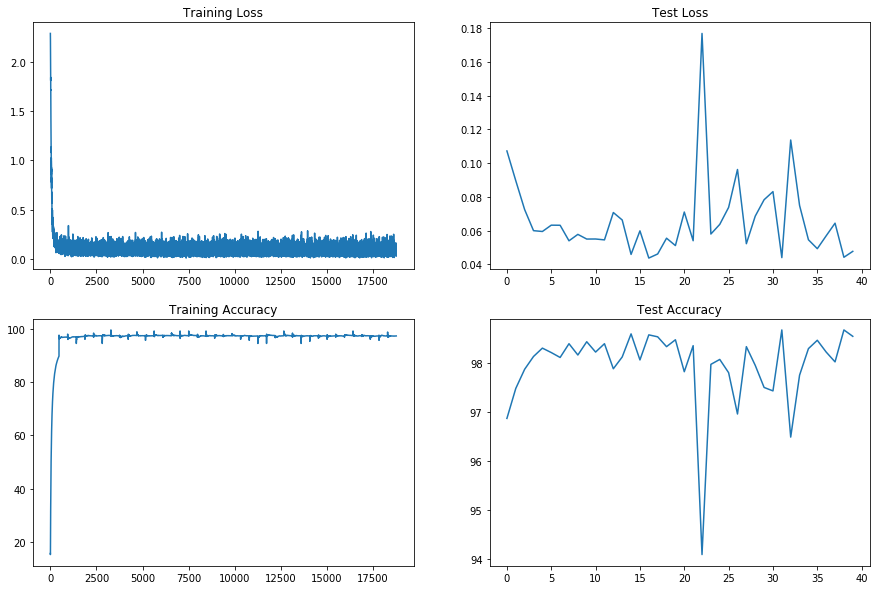

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

In [0]:
import numpy as np
def get_input_images(num):
    dataloader_args = dict(shuffle=True, batch_size=num, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)  
    test1 = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)  
    loader = torch.utils.data.DataLoader(test1, **dataloader_args)    
    dataiter = iter(loader)
    images, labels = dataiter.next()
    return images, labels

In [0]:
from torch.autograd import Variable
def predict_image(image):
    image_tensor = test_transforms(image).float()
    image_tensor = image_tensor.unsqueeze_(0)
    input = Variable(image_tensor)
    input = input.to(device)
    output = model(input)
    index = output.data.cpu().numpy().argmax()
    return index

Input image : 


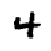

Predicted output :  8
Input image : 


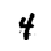

Predicted output :  8
Input image : 


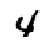

Predicted output :  8
Input image : 


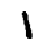

Predicted output :  8
Input image : 


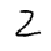

Predicted output :  8
Input image : 


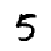

Predicted output :  8
Input image : 


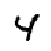

Predicted output :  8
Input image : 


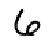

Predicted output :  0
Input image : 


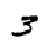

Predicted output :  8
Input image : 


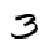

Predicted output :  8
Input image : 


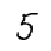

Predicted output :  8
Input image : 


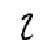

Predicted output :  8
Input image : 


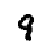

Predicted output :  8
Input image : 


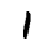

Predicted output :  8
Input image : 


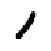

Predicted output :  8
Input image : 


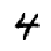

Predicted output :  8
Input image : 


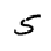

Predicted output :  8
Input image : 


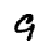

Predicted output :  8
Input image : 


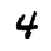

Predicted output :  8
Input image : 


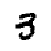

Predicted output :  8
Input image : 


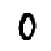

Predicted output :  8
Input image : 


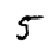

Predicted output :  8
Input image : 


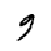

Predicted output :  8
Input image : 


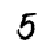

Predicted output :  0
Input image : 


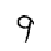

Predicted output :  8
Input :  tensor([8, 4, 4, 4, 1, 2, 0, 5, 4, 6, 3, 3, 5, 2, 0, 9, 1, 1, 8, 4, 5, 9, 4, 3,
        0, 5, 9, 5, 9, 5, 8, 0, 3, 1, 2, 3, 1, 9, 0, 0, 0, 8, 5, 7, 7, 1, 7, 6,
        2, 3, 3, 2, 4, 1, 7, 4, 8, 1, 7, 7, 7, 5, 1, 5, 3, 3, 6, 4, 1, 6, 1, 0,
        8, 7, 7, 3, 9, 1, 7, 2, 8, 7, 3, 9, 1, 6, 7, 5, 5, 8, 4, 3, 1, 9, 3, 6,
        4, 9, 7, 7])
Output :  [8, 8, 8, 8, 8, 0, 8, 8, 0, 8, 8, 8, 8, 0, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 0, 8]


In [15]:
to_pil = transforms.ToPILImage()
images, labels = get_input_images(100)

inc = 0
output = []
for ii in range(1, len(images)):
    image = to_pil(images[ii])
    index = predict_image(image)
    output.append(index)
    res = int(labels[ii]) == index
    if(res == False):
      inc += 1
      plt.subplot(5, 6, ii)
      plt.axis('off')
      print("Input image : ")
      plt.imshow(images[ii].numpy().squeeze(), cmap='gray_r')
      plt.show()
      print("Predicted output : ",index)
    if(inc == 25):
      break
          
print("Input : ",labels)      
print("Output : ",output)        

In [17]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [18]:
import os
os.chdir('/content/gdrive/My Drive/EVA4S6_Train_Test_Accu_Loss')
os.getcwd()

'/content/gdrive/My Drive/EVA4S6_Train_Test_Accu_Loss'

In [0]:
torch.save(test_acc,'with_L1_no_L2_test_acc.pt')
torch.save(test_losses,'with_L1_no_L2_test_loss.pt')

In [0]:
# torch.save(model.state_dict(),"model_with_L1_no_L2.pth")